In [ ]:
!pip install -q pyomo

In [ ]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition

## Pricing w/o Fairness

In [ ]:
from pyomo.environ import *

def pricing(Lambda1, Lambda2, b1, b2, t1=0, t2=0, d1=1, d2=1, Debug = True):

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi_10 = Var(domain=NonNegativeReals)
  model.pi_01 = Var(domain=NonNegativeReals)
  model.pi_t1 = Var(domain=NonNegativeReals)
  model.pi_t2 = Var(domain=NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c1 = Constraint(expr = model.l1 <= Lambda1)
  model.c2 = Constraint(expr = model.l2 <= Lambda2)
  model.c3 = Constraint(expr = model.l1 * model.pi_10 == model.l2 * model.pi_01)
  model.c4 = Constraint(expr = t1 * model.l1 * model.pi_10 == model.pi_t1)
  model.c5 = Constraint(expr = t2 * model.l1 * model.pi_10 == model.pi_t2)
  model.c6 = Constraint(expr = model.pi_10 + model.pi_01 + model.pi_t1 + model.pi_t2 == 1)

  # Revenue
  model.revenue = Objective(expr = model.l1 * model.pi_10 * model.p1 + model.l2 * model.pi_01 * model.p2, sense=maximize)

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('(p1, p2) = (%.3f, %.3f)' %(model.p1(), model.p2()))
    print('(l1, l2) = (%.3f, %.3f)' %(model.l1(), model.l2()))
    print('(pi_10, pi_t1, pi_01, pi_t2) = (%.3f, %.3f, %.3f, %.3f)' %(model.pi_10(), model.pi_t1(), model.pi_01(), model.pi_t2()))

  M1 = model.p1()/d1 - model.p2()/d2
  M2 = model.l1()/Lambda1 * model.pi_10() - model.l2()/Lambda2 * model.pi_01()

  return {'Price': abs(M1), 'Access': abs(M2)}

In [ ]:
def analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2):
  beta1, beta2 = b1/Lambda1, b2/Lambda2
  tau = t1+t2 # or 1/mu1 + 1/mu2

  if tau == 0:
    if np.sqrt(b2/b1) - np.sqrt(b1/b2) >= 2*np.sqrt(Lambda1/Lambda2):
      p1, p2 = 0, b2 + beta2 * (Lambda1 - np.sqrt(Lambda1 * (1+Lambda2)))
      l2 = -Lambda1 + np.sqrt(Lambda1 * (1+Lambda2))
    elif np.sqrt(b1/b2) - np.sqrt(b2/b1) >= 2*np.sqrt(Lambda2/Lambda1):
      p1, p2 = b1 + beta1 * (Lambda2 - np.sqrt(Lambda2 * (1+Lambda1))), 0
    else:
      p1, p2 =  b1 - np.sqrt(beta1)/2 * (b1+b2)/(np.sqrt(beta1)+np.sqrt(beta2)), b2 - np.sqrt(beta2)/2 * (b1+b2)/(np.sqrt(beta1)+np.sqrt(beta2))
  else:
    if np.sqrt(b2/b1) - np.sqrt(b1/b2) >= 2*np.sqrt(Lambda1/Lambda2) + Lambda1 * np.sqrt(b1/b2) * tau: # l1 = Lambda
      l1 = Lambda1
      l2 = (np.sqrt(Lambda1*Lambda1 + (1 + Lambda1 * tau)*Lambda1*Lambda2)-Lambda1)/(1+Lambda1*tau)
      p1, p2 = b1 * (1-l1/Lambda1), b2 * (1-l2/Lambda2)
    elif np.sqrt(b1/b2) - np.sqrt(b2/b1) >= 2*np.sqrt(Lambda2/Lambda1) + Lambda2 * np.sqrt(b2/b1) * tau:
      l1 = (np.sqrt(Lambda2*Lambda2 + (1 + Lambda2 * tau)*Lambda2*Lambda1)-Lambda2)/(1+Lambda2*tau)
      l2 = Lambda2
      p1, p2 = b1 * (1-l1/Lambda1), b2 * (1-l2/Lambda2)
    else:
      beta = np.sqrt(beta1) + np.sqrt(beta2)
      num = np.sqrt(beta*beta+tau*(b1+b2)) - beta
      l1 = num / (tau * np.sqrt(beta1))
      l2 = num / (tau * np.sqrt(beta2))
      p1, p2 =  b1 * (1-l1/Lambda1), b2 * (1-l2/Lambda2)

  print('(p1, p2) = (%.3f, %.3f)' %(p1, p2))

In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 4, 1
b1, b2 = 4, 1
t1, t2 = 0, 0
M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2)


Revenue =  1.5278651927316678
Optimal Variables
(p1, p2) = (2.762, 0.000)
(l1, l2) = (1.238, 1.000)
(pi_10, pi_t1, pi_01, pi_t2) = (0.447, 0.000, 0.553, -0.000)
(p1, p2) = (2.764, 0.000)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 4, 1
b1, b2 = 4, 1
t1, t2 = 1, 1
M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2)


Revenue =  0.7583426134572915
Optimal Variables
(p1, p2) = (3.129, 0.129)
(l1, l2) = (0.871, 0.871)
(pi_10, pi_t1, pi_01, pi_t2) = (0.267, 0.233, 0.267, 0.233)
(p1, p2) = (3.129, 0.129)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 4, 1
b1, b2 = 4, 1
t1, t2 = 0.1, 0.1
M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2)


Revenue =  1.3773348458632562
Optimal Variables
(p1, p2) = (2.826, 0.000)
(l1, l2) = (1.174, 1.000)
(pi_10, pi_t1, pi_01, pi_t2) = (0.415, 0.049, 0.487, 0.049)
(p1, p2) = (2.826, 0.000)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 1, 1
b1, b2 = 1, 4
t1, t2 = 3, 2
M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2)


Revenue =  0.3205739624209992
Optimal Variables
(p1, p2) = (0.432, 2.868)
(l1, l2) = (0.568, 0.283)
(pi_10, pi_t1, pi_01, pi_t2) = (0.171, 0.291, 0.343, 0.194)
(p1, p2) = (0.434, 2.868)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 2, 1
b1, b2 = 1, 5
t1, t2 = 1, 1
M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2, t1, t2)


Revenue =  0.6419238881865516
Optimal Variables
(p1, p2) = (0.433, 3.208)
(l1, l2) = (1.133, 0.358)
(pi_10, pi_t1, pi_01, pi_t2) = (0.156, 0.176, 0.492, 0.176)
(p1, p2) = (0.433, 3.208)


## Pricing w/ Fair Constraints

In [ ]:
from pyomo.environ import *

def fair_pricing(Lambda1, Lambda2, b1, b2, M_star, alpha, t1=0, t2=0, d1=1, d2=1, criteria = 'Price', Debug = True):

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi_10 = Var(domain=NonNegativeReals)
  model.pi_01 = Var(domain=NonNegativeReals)
  model.pi_t1 = Var(domain=NonNegativeReals)
  model.pi_t2 = Var(domain=NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c1 = Constraint(expr = model.l1 <= Lambda1)
  model.c2 = Constraint(expr = model.l2 <= Lambda2)
  model.c3 = Constraint(expr = model.l1 * model.pi_10 == model.l2 * model.pi_01)
  model.c4 = Constraint(expr = t1 * model.l1 * model.pi_10 == model.pi_t1)
  model.c5 = Constraint(expr = t2 * model.l1 * model.pi_10 == model.pi_t2)
  model.c6 = Constraint(expr = model.pi_10 + model.pi_01 + model.pi_t1 + model.pi_t2 == 1)

  # Revenue
  model.revenue = Objective(expr = model.l1 * model.pi_10 * model.p1 + model.l2 * model.pi_01 * model.p2, sense=maximize)

  M_star = M_star[criteria]
  if criteria == 'Price':
    model.f1 = Constraint(expr = model.p1/d1 - model.p2/d2 <= (1-alpha) * M_star)
    model.f2 = Constraint(expr = model.p2/d2 - model.p1/d1 <= (1-alpha) * M_star)
  elif criteria == 'Access':
    model.f1 = Constraint(expr = model.l1/Lambda1 * model.pi_10 - model.l2/Lambda2 * model.pi_01 <= (1-alpha) * M_star)
    model.f2 = Constraint(expr = model.l2/Lambda2 * model.pi_01 - model.l1/Lambda1 * model.pi_10 <= (1-alpha) * M_star)
  else:
    print("Warning: no criteria matached")

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('p1 =', model.p1())
    print('p2 =', model.p2())
    print('l1 = ', model.l1())
    print('l2 = ', model.l2())
    print('pi_10 =', model.pi_10())
    print('pi_01 =', model.pi_01())

  S1 = 1/(2*Lambda1) * model.l1() * model.l2() / (model.l1() + model.l2() + (t1+t2)*model.l1()*model.l2()) * (b1-model.p1())
  S2 = 1/(2*Lambda2) * model.l1() * model.l2() / (model.l1() + model.l2() + (t1+t2)*model.l1()*model.l2()) * (b2-model.p2())
  total_surplus = Lambda1 * S1 + Lambda2 * S2

  return [model.p1(), model.p2()], model.revenue(), [S1, S2], total_surplus, [model.l1()/Lambda1 * model.pi_10(), model.l2()/Lambda2 * model.pi_01()], [model.pi_10(), model.pi_01()]

## Plots

In [ ]:
def simulator(Lambda1, Lambda2, b1, b2, t1=0, t2=0, d1=1, d2=1, criteria_list=['Price', 'Access'], n_iter=10, Debug=False):
  M_star = pricing(Lambda1, Lambda2, b1, b2, t1, t2, d1, d2, Debug)

  price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = {}, {}, {}, {}, {}, {}
  for criteria in criteria_list:
    price_list, revenue_list, surplus_list, total_surplus_list, access_list = [], [], [], [], []
    pi_list = [[] for i in range(2)]
    for a in range(n_iter+1):
      price, revenue, surplus, total_surplus, access, steady_state = fair_pricing(Lambda1, Lambda2, b1, b2, M_star, a/n_iter, t1, t2, d1, d2, criteria = criteria, Debug=Debug)
      price_list.append(price)
      revenue_list.append(revenue)
      surplus_list.append(surplus)
      total_surplus_list.append(total_surplus)
      access_list.append(access)
      for j in range(len(steady_state)):
        pi_list[j].append(steady_state[j])

    price_all[criteria] = price_list
    revenue_all[criteria] = revenue_list
    surplus_all[criteria] = surplus_list
    total_surplus_all[criteria] = total_surplus_list
    access_all[criteria] = access_list
    pi_all[criteria] = pi_list

  return price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all

In [ ]:
from google.colab import files
def subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, d=[1,1], _filename='figure'):
  price_list, revenue_list, surplus_list, total_surplus_list, access_list, pi_list\
   = price_all[criteria], revenue_all[criteria], surplus_all[criteria], total_surplus_all[criteria], access_all[criteria], pi_all[criteria]

  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 28
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1)/10 for i in range(n_iter)]

  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0, linestyle='--')
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0, linestyle=':')

  axs[0].grid()

  axs[1].plot(iter_list, [p[0]/d[0] for p in price_list], label=r'$p_1$',linewidth=3.0)
  axs[1].plot(iter_list, [p[1]/d[1] for p in price_list], label=r'$p_2$',linewidth=3.0, linestyle='--')
  #axs[1].set_xlim([0, 0.01])
  axs[1].grid()

  axs[2].plot(iter_list, [s[0] for s in access_list], label=r'$A_1$',linewidth=3.0)#\Pi_1q_1
  axs[2].plot(iter_list, [s[1] for s in access_list], label=r'$A_2$',linewidth=3.0, linestyle='--')
  #axs[2].set_xlim([0, 0.01])
  axs[2].grid()

  axs[3].plot(iter_list, [s[0] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0)
  axs[3].plot(iter_list, [s[1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0, linestyle='--')
  #axs[3].set_xlim([0, 0.01])
  axs[3].grid()

  for i in range(4):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})
    axs[i].set_xlim([0, 1/10])

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.savefig(_filename + '.pdf', format='pdf', bbox_inches='tight')
  files.download(_filename + '.pdf')
  plt.show()

## Experiments

In [ ]:
criteria_list = ['Price']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

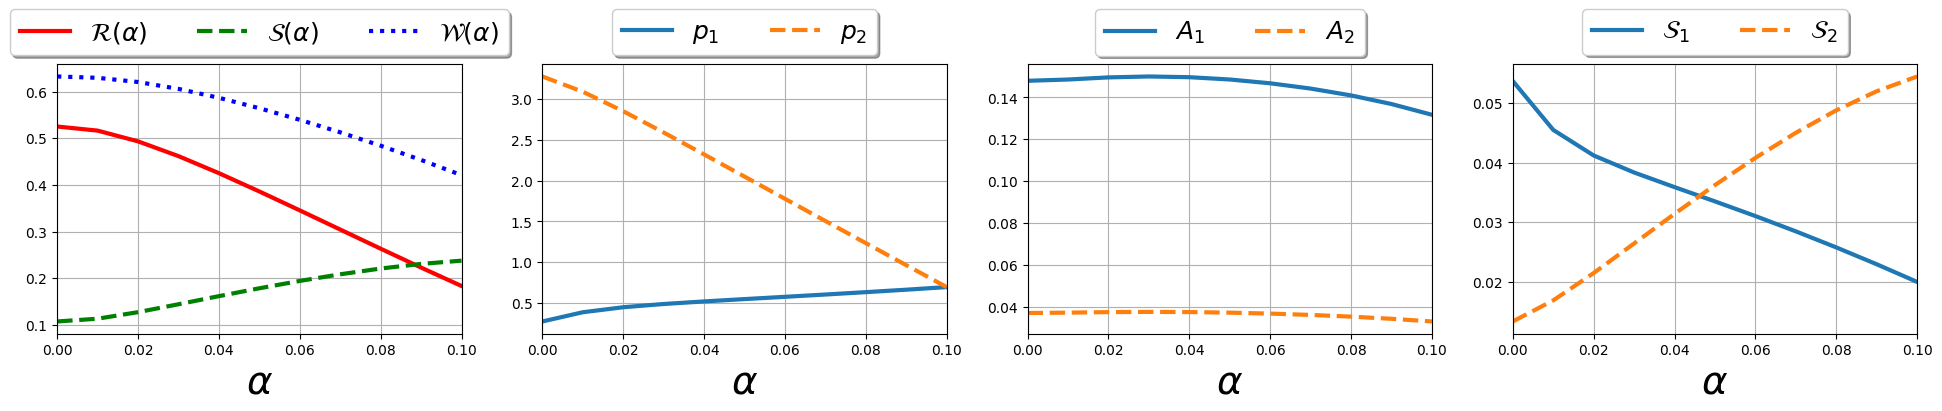

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 4
t1, t2 = 2, 2
price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, t1, t2, d1=1, d2=1, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, _filename='price_mu_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

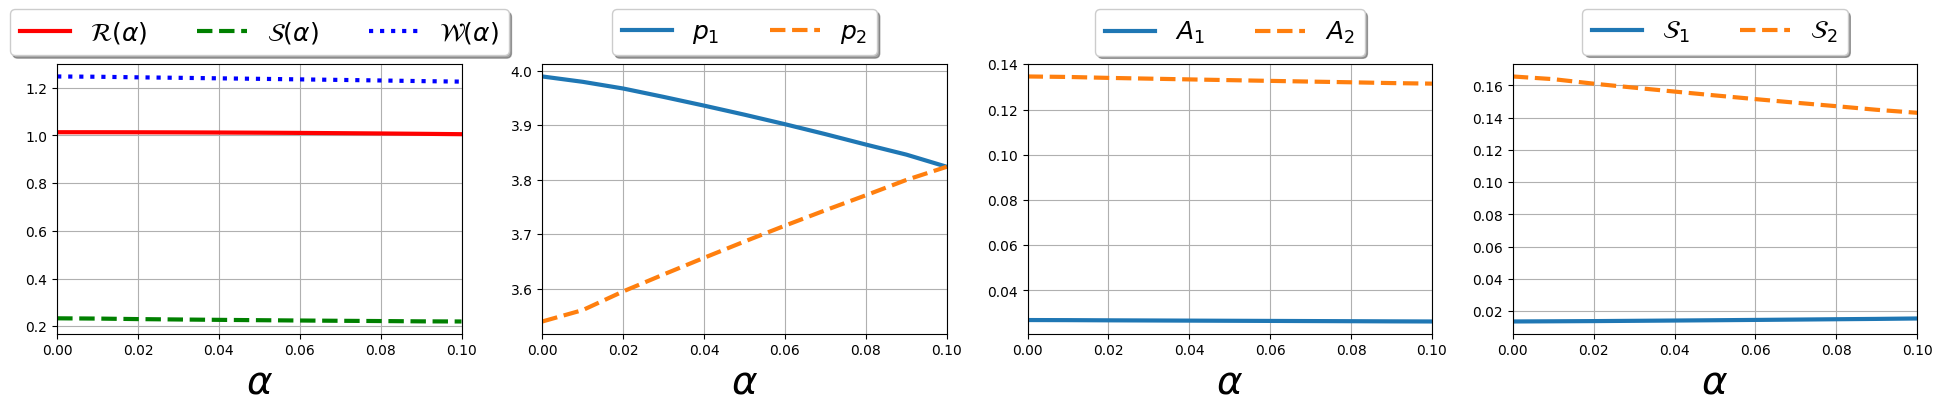

In [ ]:
Lambda1, Lambda2 = 5, 1
b1, b2 = 5, 6
t1, t2 = 2, 2
price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, t1, t2, d1=1, d2=1, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, _filename = 'price_mu_2')

### Access Fairness

In [ ]:
def access_analytics(b1, b2, Lambda1, Lambda2, t1, t2):
  price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = {'Access': []}, {'Access': []}, {'Access': []}, {'Access': []}, {'Access': []}, {'Access': [[],[]]}

  tau = t1 + t2
  beta1, beta2 = b1/Lambda1, b2/Lambda2
  sum_sq_beta = np.sqrt(beta1) + np.sqrt(beta2)
  A = np.sqrt(pow(sum_sq_beta,2)+tau*(b1+b2)) - sum_sq_beta
  l1_star, l2_star = A/(tau*np.sqrt(beta1)), A/(tau*np.sqrt(beta2))

  for a in range(11):
    alpha = a/10
    if alpha != 1:
      l1_alpha = (1-alpha) * sum_sq_beta * l1_star/(sum_sq_beta + alpha * np.sqrt(beta1) * tau * l1_star)
      l2_alpha = (1-alpha) * sum_sq_beta * l2_star/(sum_sq_beta + alpha * np.sqrt(beta2) * tau * l2_star)
      p1 = b1 * (1-l1_alpha/Lambda1)
      p2 = b2 * (1-l2_alpha/Lambda2)
      pi_1 = l2_alpha/(l1_alpha+l2_alpha+tau*l1_alpha*l2_alpha)
      pi_2 = l1_alpha/(l1_alpha+l2_alpha+tau*l1_alpha*l2_alpha)
      A1, A2 = l1_alpha * pi_1/Lambda1, l2_alpha * pi_2/Lambda2
      S1= (b1-p1)/(2*Lambda1) * l1_alpha * pi_1
      S2= (b2-p2)/(2*Lambda2) * l2_alpha * pi_2
    else:
      l1_alpha, l2_alpha = 0, 0
      p1, p2 = b1, b2
      pi_1, pi_2 = 1/2, 1/2
      A1, A2 = 0, 0
      S1, S2 = 0, 0
    R = p1 * l1_alpha * pi_1 + p2 * l2_alpha * pi_2
    TS = Lambda1 * S1 + Lambda2 * S2
    W = R + TS

    price_all['Access'].append([p1, p2])
    revenue_all['Access'].append(R)
    surplus_all['Access'].append([S1,S2])
    total_surplus_all['Access'].append(TS)
    access_all['Access'].append([A1, A2])
    pi_all['Access'][0].append(pi_1)
    pi_all['Access'][1].append(pi_2)
  return price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all

In [ ]:
criteria_list = ['Access']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

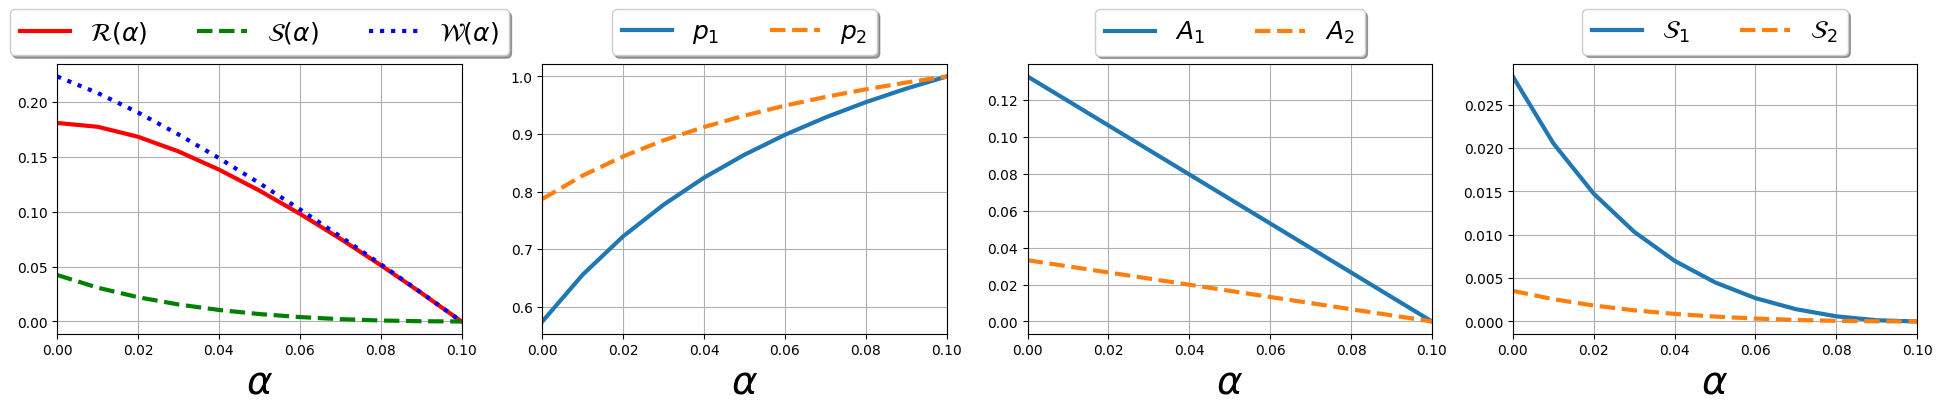

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 1
t1, t2 = 2, 2
price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, t1, t2, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, _filename='access_fair_mu1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

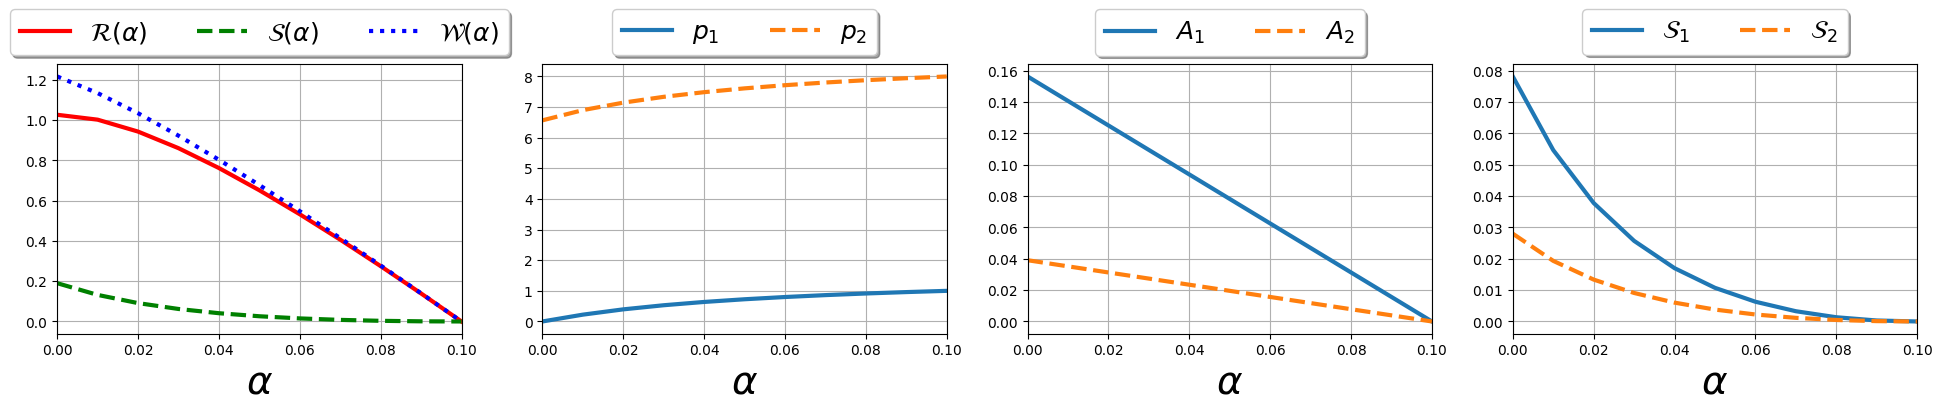

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 8
t1, t2 = 2, 2
price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, t1, t2, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, _filename = 'access_fair_mu2')